<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [64]:
# !pip install -r requirements.txt

In [65]:
import warnings
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

In [66]:
# plt.style.use('~/.config/matplotlib/stylelib/dracula.mplstyle')

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [67]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:]  #лучше избавиться от нескольких пропущенных значений в начале сразу,
#могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /Users/nikitasigal/repos/ML.dev/iad-workspace/3-applied-ds/hw/hw3-time/atm_daily_cash.csv
26.1kB [00:00, 12.2MB/s]                   


Взглянем на то, что представляют из себя данные:

In [68]:
df.head()

,Date,CashIn,CashOut
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN


В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [69]:
df['CashOut'] = -df['CashOut']
df['Balance'] = df['CashIn'] + df['CashOut']
df.head()

,Date,CashIn,CashOut,Balance
4,1/5/2016,20840.0,-22200.0,-1360.0
5,1/6/2016,28460.0,-18810.0,9650.0
6,1/7/2016,19250.0,-23210.0,-3960.0
7,1/8/2016,49770.0,-4350.0,45420.0
8,1/9/2016,NaN,NaN,NaN


### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [70]:
df.isna().sum(axis=0)

Date         0
CashIn     101
CashOut     88
Balance    110
dtype: int64

> Почти 10% записей не полны – впоследствии на придется их заполнить

In [71]:
df.describe()

,CashIn,CashOut,Balance
count,1081.000000,1094.000000,1072.000000
mean,37261.618871,-30985.648995,5976.651119
std,20583.186636,18314.048275,21551.659802
min,100.000000,-111700.000000,-75190.000000
25%,21690.000000,-40375.000000,-6277.500000
50%,34980.000000,-27895.000000,5320.000000
75%,50280.000000,-18010.000000,18515.000000
max,121300.000000,-0.000000,85160.000000


> Большинство транзакций относительно небольшие по объему. Более того, в большинстве случаев объем снятых денег примерно равен объему внесенных – 50% значений `Balance` лежит в небольшом промежутке от -6к до 19к

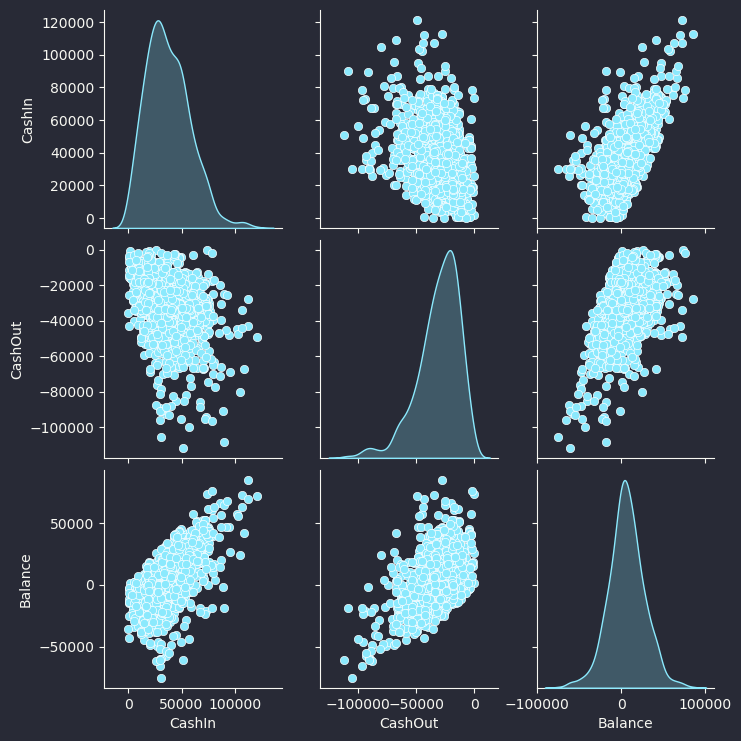

In [72]:
sns.pairplot(df, diag_kind="kde")

> Более наглядная презентация предыдущих выводов – пик баланса приходится практически ровно на ноль

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

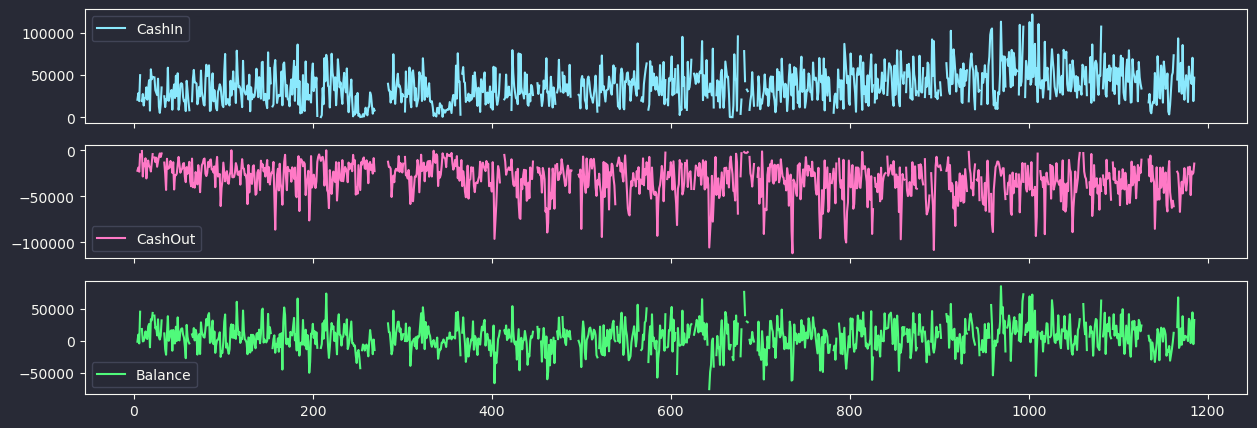

In [126]:
df.plot(subplots=True, figsize=(15, 5))

> Даже без дополнительных графиков можно увидеть недельную и месячную сезонность – особенно на `CashOut`. Но какого-то сильного тренда нет – объем в целом практически не меняется

<Axes: >

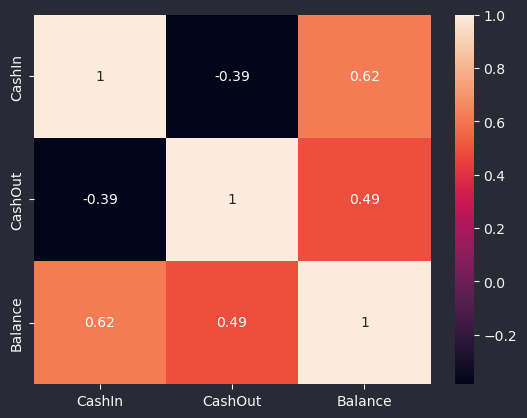

In [74]:
sns.heatmap(df.corr("pearson"), annot=True)

> Корреляция с балансом очевидна и особо нас не интересует. `CashIn` и `CashOut` коррелируют не так сильно, как можно подумать, но это логично – паттерны снятия и пополнения банкоматов и не должны совпадать

> Более подробный анализ проведем уже в следующих секциях после приведения к `TSDataset`

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [75]:
from etna.datasets import TSDataset

In [76]:
molten = df.melt(id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'Balance'], var_name='segment',
                 value_name='target').rename(columns={'Date': 'timestamp'})
molten.head(10)

,timestamp,segment,target
0,1/5/2016,CashIn,20840.0
1,1/6/2016,CashIn,28460.0
2,1/7/2016,CashIn,19250.0
3,1/8/2016,CashIn,49770.0
4,1/9/2016,CashIn,NaN
5,1/10/2016,CashIn,19260.0
6,1/11/2016,CashIn,27590.0
7,1/12/2016,CashIn,14060.0
8,1/13/2016,CashIn,22550.0
9,1/14/2016,CashIn,23310.0


In [77]:
ts = TSDataset.to_dataset(molten)
ts = TSDataset(ts, freq='D')
ts.head()

segment,Balance,CashIn,CashOut
feature,target,target,target
timestamp,,,
2016-01-05,-1360.0,20840.0,-22200.0
2016-01-06,9650.0,28460.0,-18810.0
2016-01-07,-3960.0,19250.0,-23210.0
2016-01-08,45420.0,49770.0,-4350.0
2016-01-09,NaN,NaN,NaN


In [78]:
ts.describe()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
Balance       2016-01-05    2019-03-31    1182          110
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88


### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [79]:
from etna.transforms.missing_values.imputation import TimeSeriesImputerTransform

ts_v1 = deepcopy(ts)
ts_v1.fit_transform(
    [
        TimeSeriesImputerTransform(strategy="seasonal", seasonality=30),
        TimeSeriesImputerTransform(strategy="mean", window=30),
    ]
)
ts_v1.describe()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
Balance       2016-01-05    2019-03-31    1182            0
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0


> Удаляя записи с пропущенными данными мы бы потеряли 10% датасета – такое мы себе позволить не можем, а занулять данные очевидно нельзя.
> Учитывая сезонность датасета, вполне логично попробовать восстановить данные за счет средних сезонных значений, а если не получается – использовать среднее за 30 дней 

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

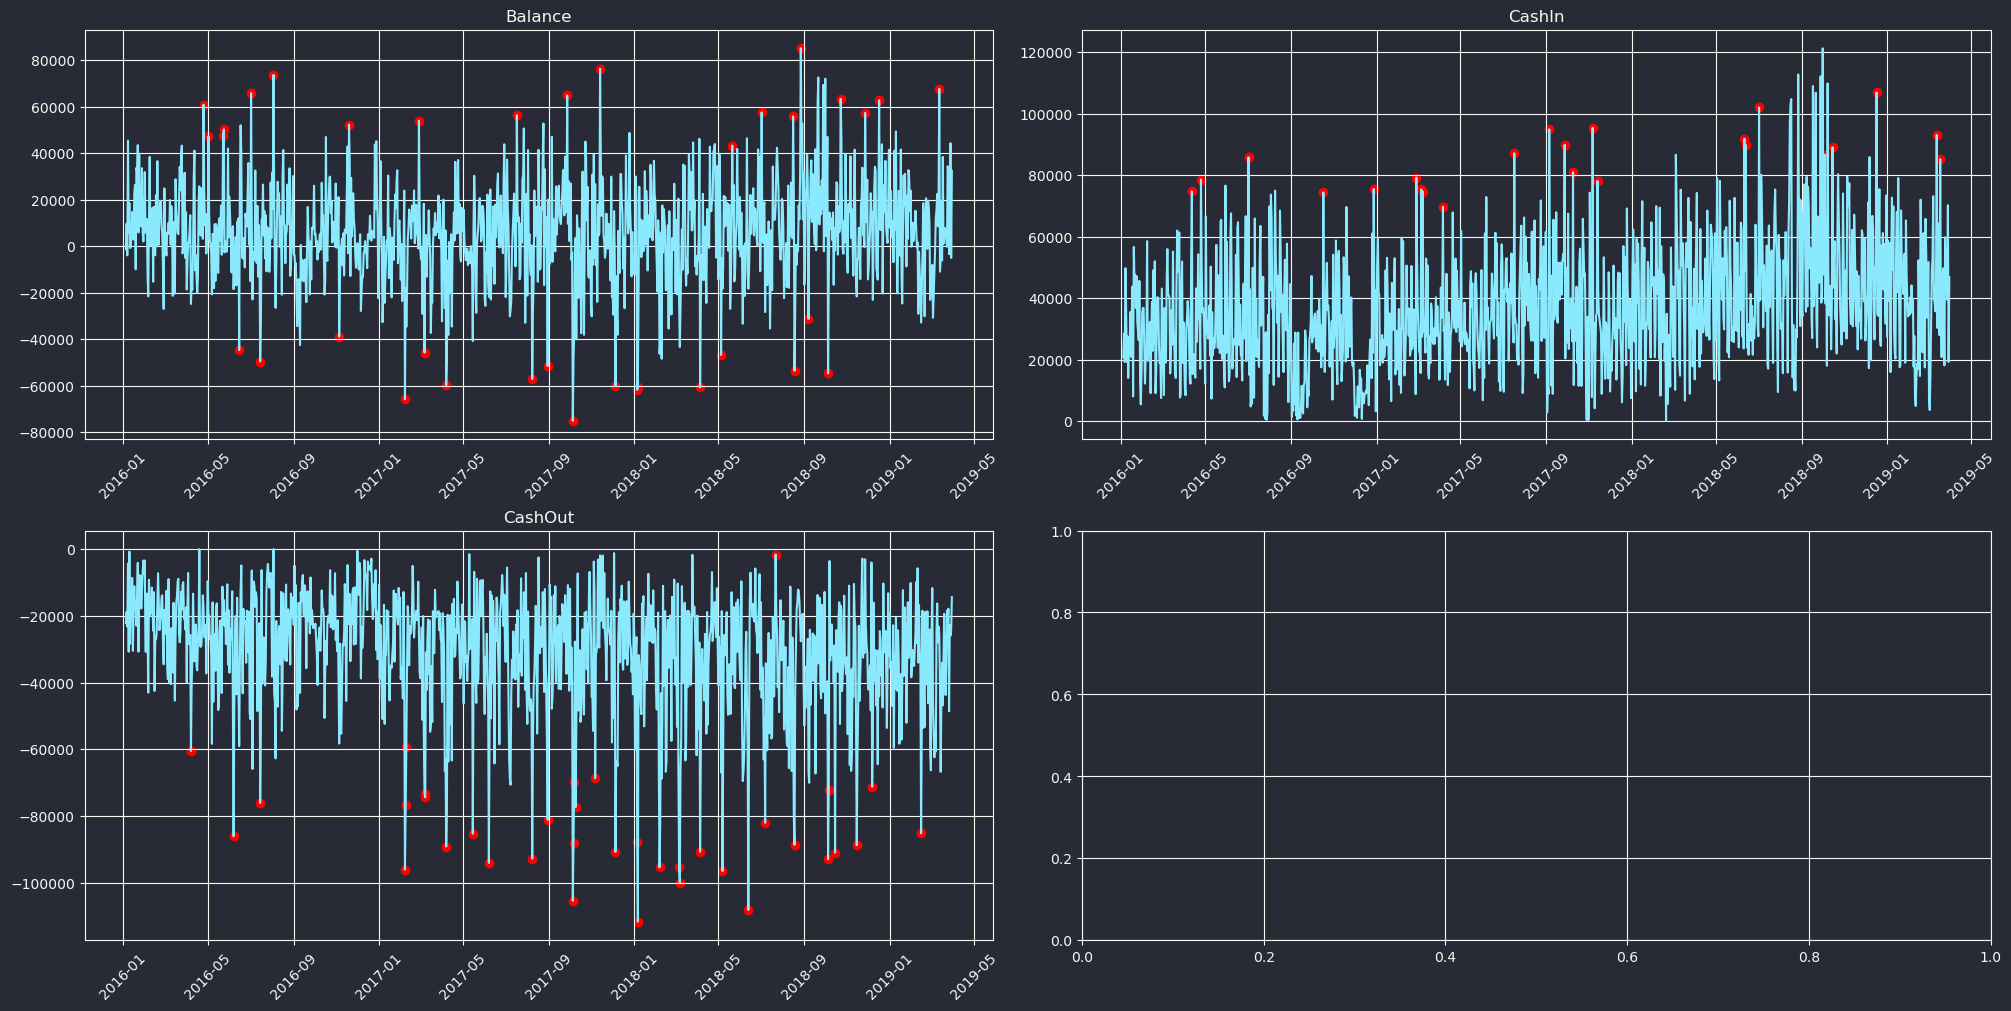

In [80]:
from etna.analysis.outliers import get_anomalies_density
from etna.analysis import plot_anomalies, plot_anomalies_interactive

# params = {'window_size': (5, 20, 1), 'distance_coef': (0.25, 3, 0.25)}
# plot_anomalies_interactive(ts_imputed, segment='target', method=get_anomalies_density, params_bounds=params)

anomalies_target = get_anomalies_density(ts_v1, window_size=20, distance_coef=1)
plot_anomalies(ts_v1, anomaly_dict=anomalies_target)

> Интерактивно подбирать параметры можно, к сожалению, только на одном сегменте, так будем ориентироваться на таргет. Будем использовать DensityOutliers, как более тонко настраиваемый

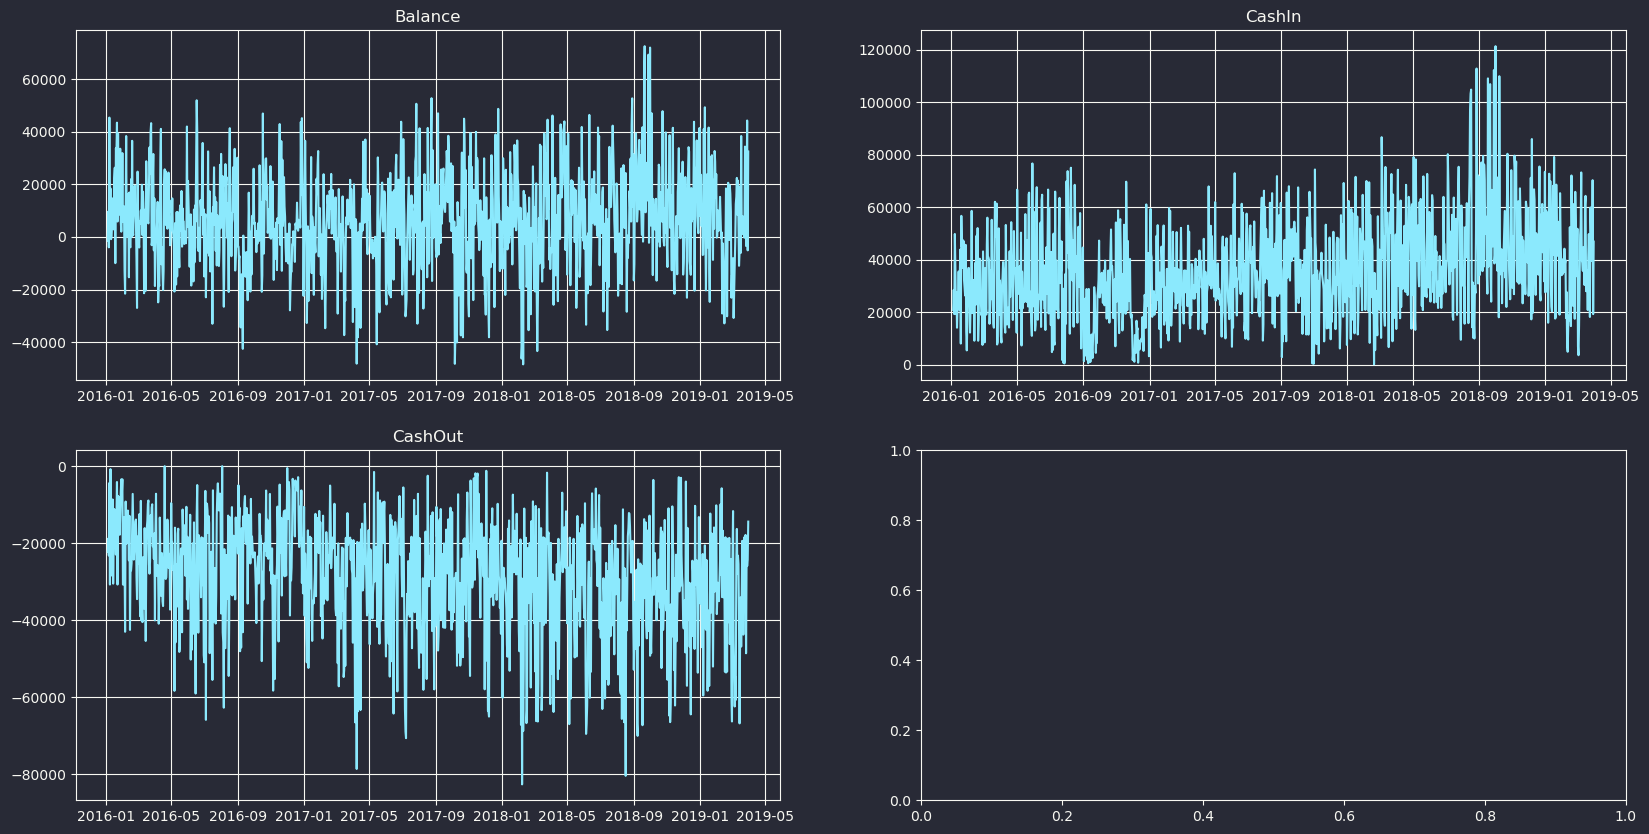

In [81]:
from etna.transforms.outliers import DensityOutliersTransform

ts_v1.fit_transform(
    [
        DensityOutliersTransform(in_column="target", window_size=20, distance_coef=1),
        TimeSeriesImputerTransform(strategy="mean", window=30),
    ]
)
ts_v1.plot()

In [82]:
ts_v1.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
Balance,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
CashIn,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
CashOut,2016-01-05,2019-03-31,1182,0,3,0,0,0,D


### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [83]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [84]:
HORIZON = 5
HISTORY = HORIZON * 5
METRICS = [MAE(), SMAPE()]

In [85]:
model = ProphetModel()
transforms = []
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [86]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts_v1, metrics=METRICS, aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - I

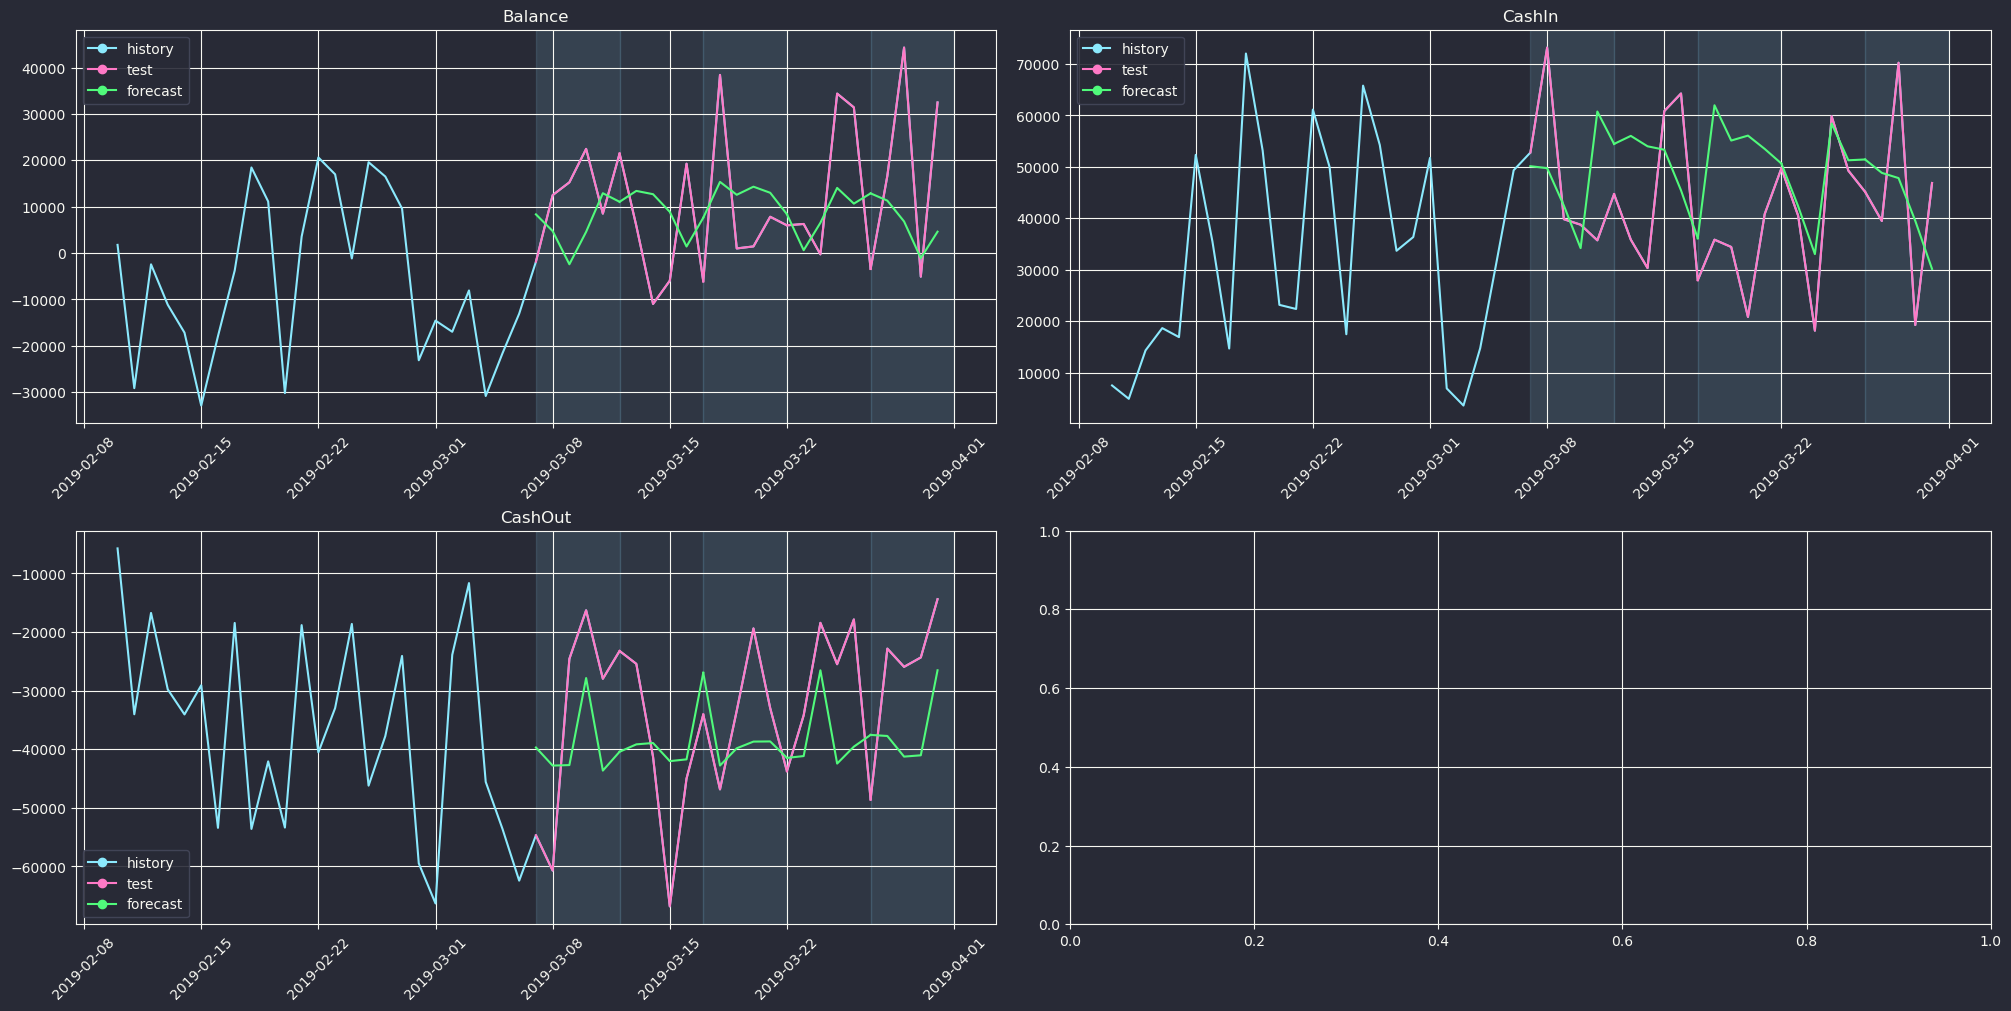

In [87]:
plot_backtest(forecast_df=forecast_df, ts=ts_v1, history_len=HISTORY)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [88]:
metrics_df

,segment,MAE,SMAPE
0,Balance,13826.485611,131.756863
1,CashIn,13497.617113,31.222906
2,CashOut,12330.632776,36.802971


> Сдесь сразу очевидна разница между метриками – `MAE` почти равны, но из-за того, что значения `Balance` относительно малы, `SMAPE` для него больше в 4 раза.

> Тем не менее, для любых метрик очевидно одно – итоговое значение лучше предсказывать как сумму `CashIn` и `CashOut`, так как качество по обоим параметрам выше и выявлять паттерны в отдельных рядах намного легче.

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [89]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [90]:
molten = df.melt(id_vars=['Date'], value_vars=['CashIn', 'CashOut'], var_name='segment',
                 value_name='target').rename(columns={'Date': 'timestamp'})
molten.sample(10)

,timestamp,segment,target
1687,5/24/2017,CashOut,-22520.0
2293,1/20/2019,CashOut,-12300.0
256,9/17/2016,CashIn,5080.0
1549,1/6/2017,CashOut,-50960.0
932,7/25/2018,CashIn,75360.0
542,6/30/2017,CashIn,51870.0
607,9/3/2017,CashIn,11760.0
1462,10/11/2016,CashOut,-12380.0
1870,11/23/2017,CashOut,-27420.0
2119,7/30/2018,CashOut,NaN


In [91]:
hdf = TSDataset.to_dataset(molten)
hdf.head()

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN


In [92]:
h_structure = HierarchicalStructure(
    level_structure={"Balance": ["CashIn", "CashOut"]}, level_names=["total", "cashflow"]
)
h_structure

HierarchicalStructure(level_structure = {'Balance': ['CashIn', 'CashOut']}, level_names = ['total', 'cashflow'], )

In [93]:
hts = TSDataset(df=hdf, freq='D', hierarchical_structure=h_structure)
hts

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN
...,...,...
2019-03-27,45160.0,-48600.0
2019-03-28,39480.0,-22840.0


In [94]:
hts.current_df_level

'cashflow'

In [95]:
reconciliator = BottomUpReconciliator(source_level='cashflow', target_level='total')
reconciliator.fit(hts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [96]:
reconciliator.aggregate(ts=hts)

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN
...,...,...
2019-03-27,45160.0,-48600.0
2019-03-28,39480.0,-22840.0


Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [97]:
hts.fit_transform(
    [
        TimeSeriesImputerTransform(strategy="seasonal", seasonality=30),
        TimeSeriesImputerTransform(strategy="mean", window=30),
        DensityOutliersTransform(in_column="target", window_size=20, distance_coef=1),
        TimeSeriesImputerTransform(strategy="mean", window=30),
    ]
)

In [98]:
pipeline = HierarchicalPipeline(
    transforms=transforms,
    model=model,
    reconciliator=reconciliator,
    horizon=HORIZON
)

In [99]:
metrics_df, forecast_df, _ = pipeline.backtest(
    ts=hts, metrics=METRICS, aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
21:43:51 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
21:43:51 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
21:43:51 - cmdstanpy - INFO - Chain [1] start processing
21:43:52 - cmdstanpy - INFO - Chain [1] done processing
21:43:52 - cmdstanpy - INFO - Chain [1] start processing
21:43:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
2

In [100]:
metrics_df

,segment,MAE,SMAPE
0,Balance,14420.901155,130.98919


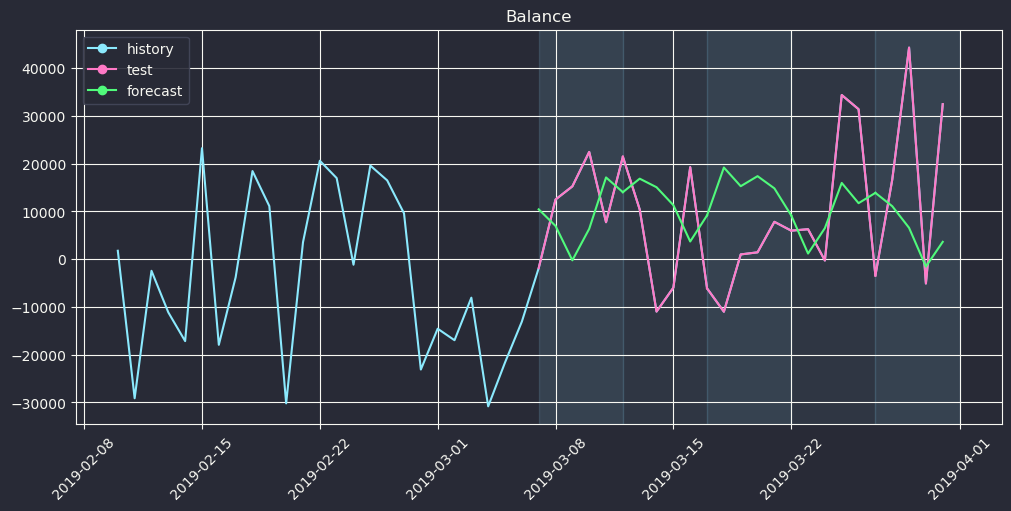

In [101]:
plot_backtest(forecast_df=forecast_df, ts=hts.get_level_dataset('total'), history_len=HISTORY)

> Улучшение, конечно, есть, но очень не значительное – буквально 1% по `SMAPE`. Более того, `MAE` даже просело на 1к. Так что подход интересный, но требует большей настройки и изучения.

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [102]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

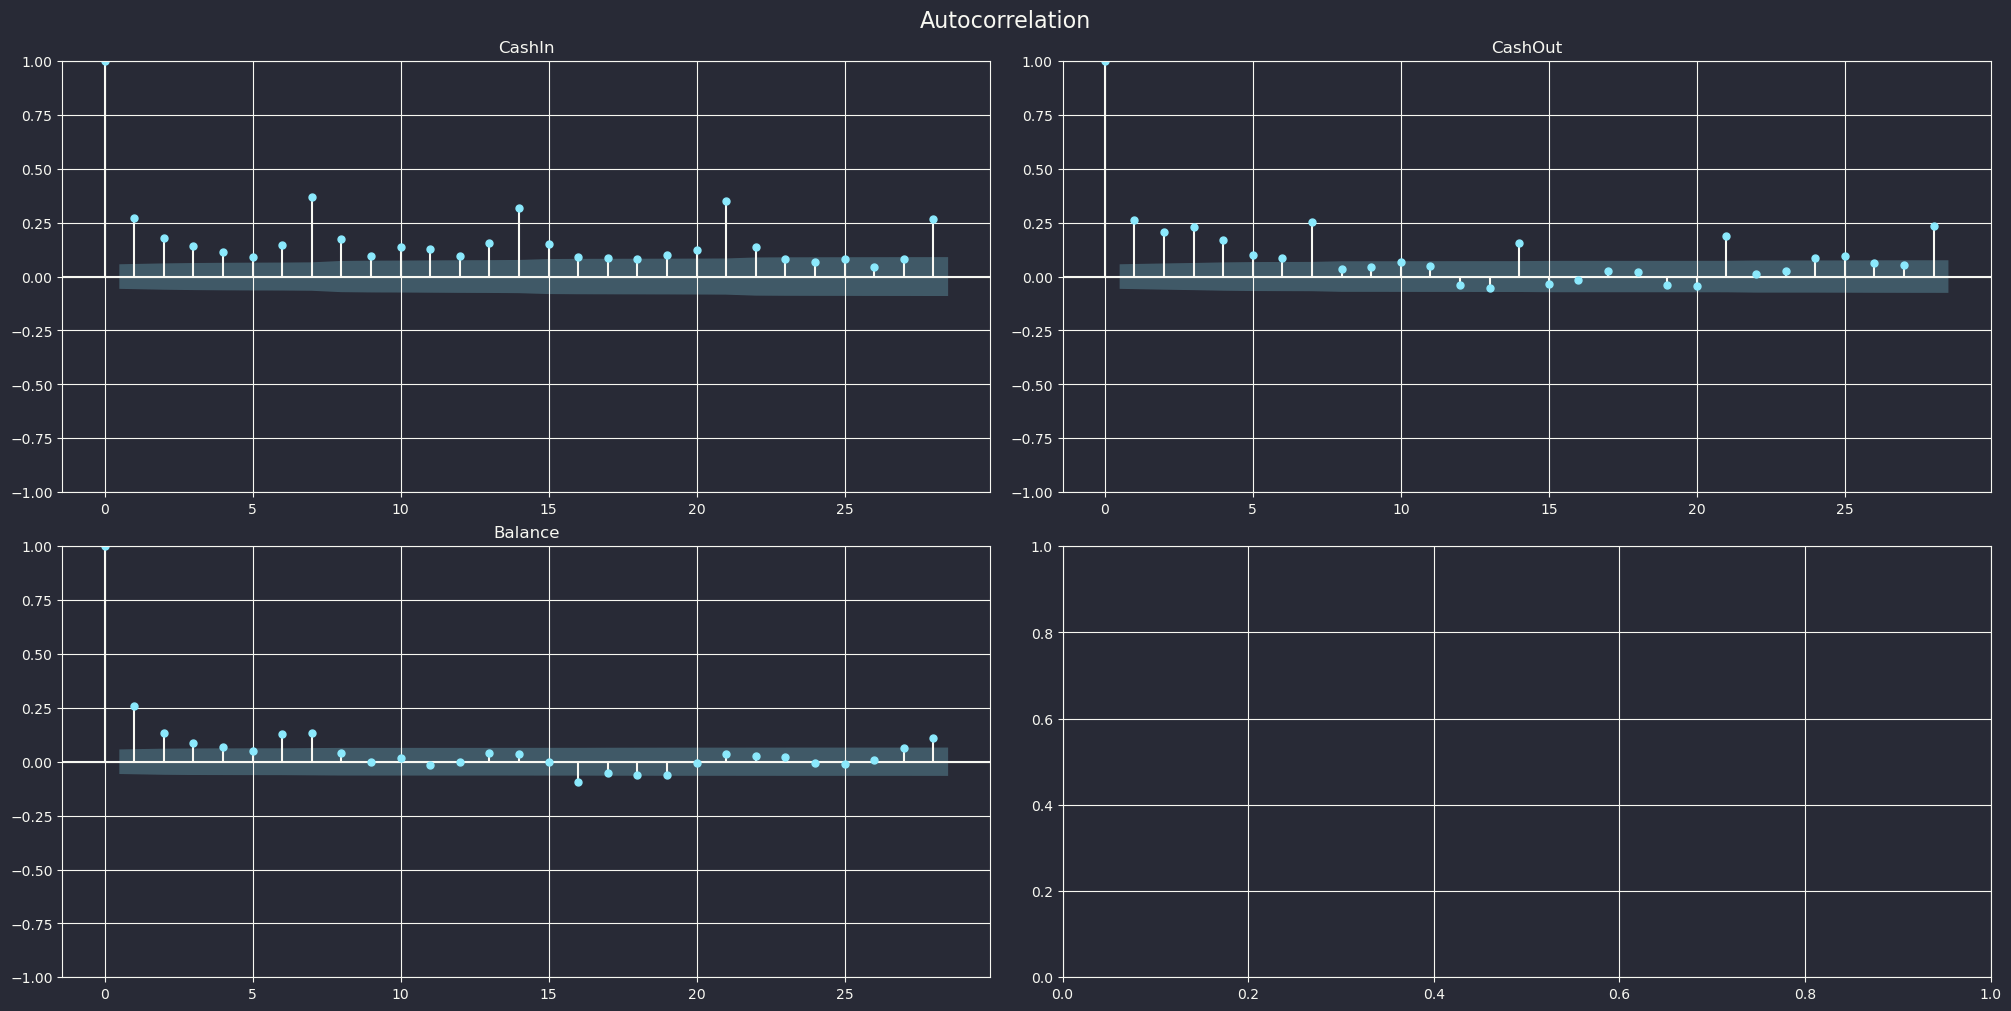

In [103]:
sample_acf_plot(ts=ts_v1, lags=28)

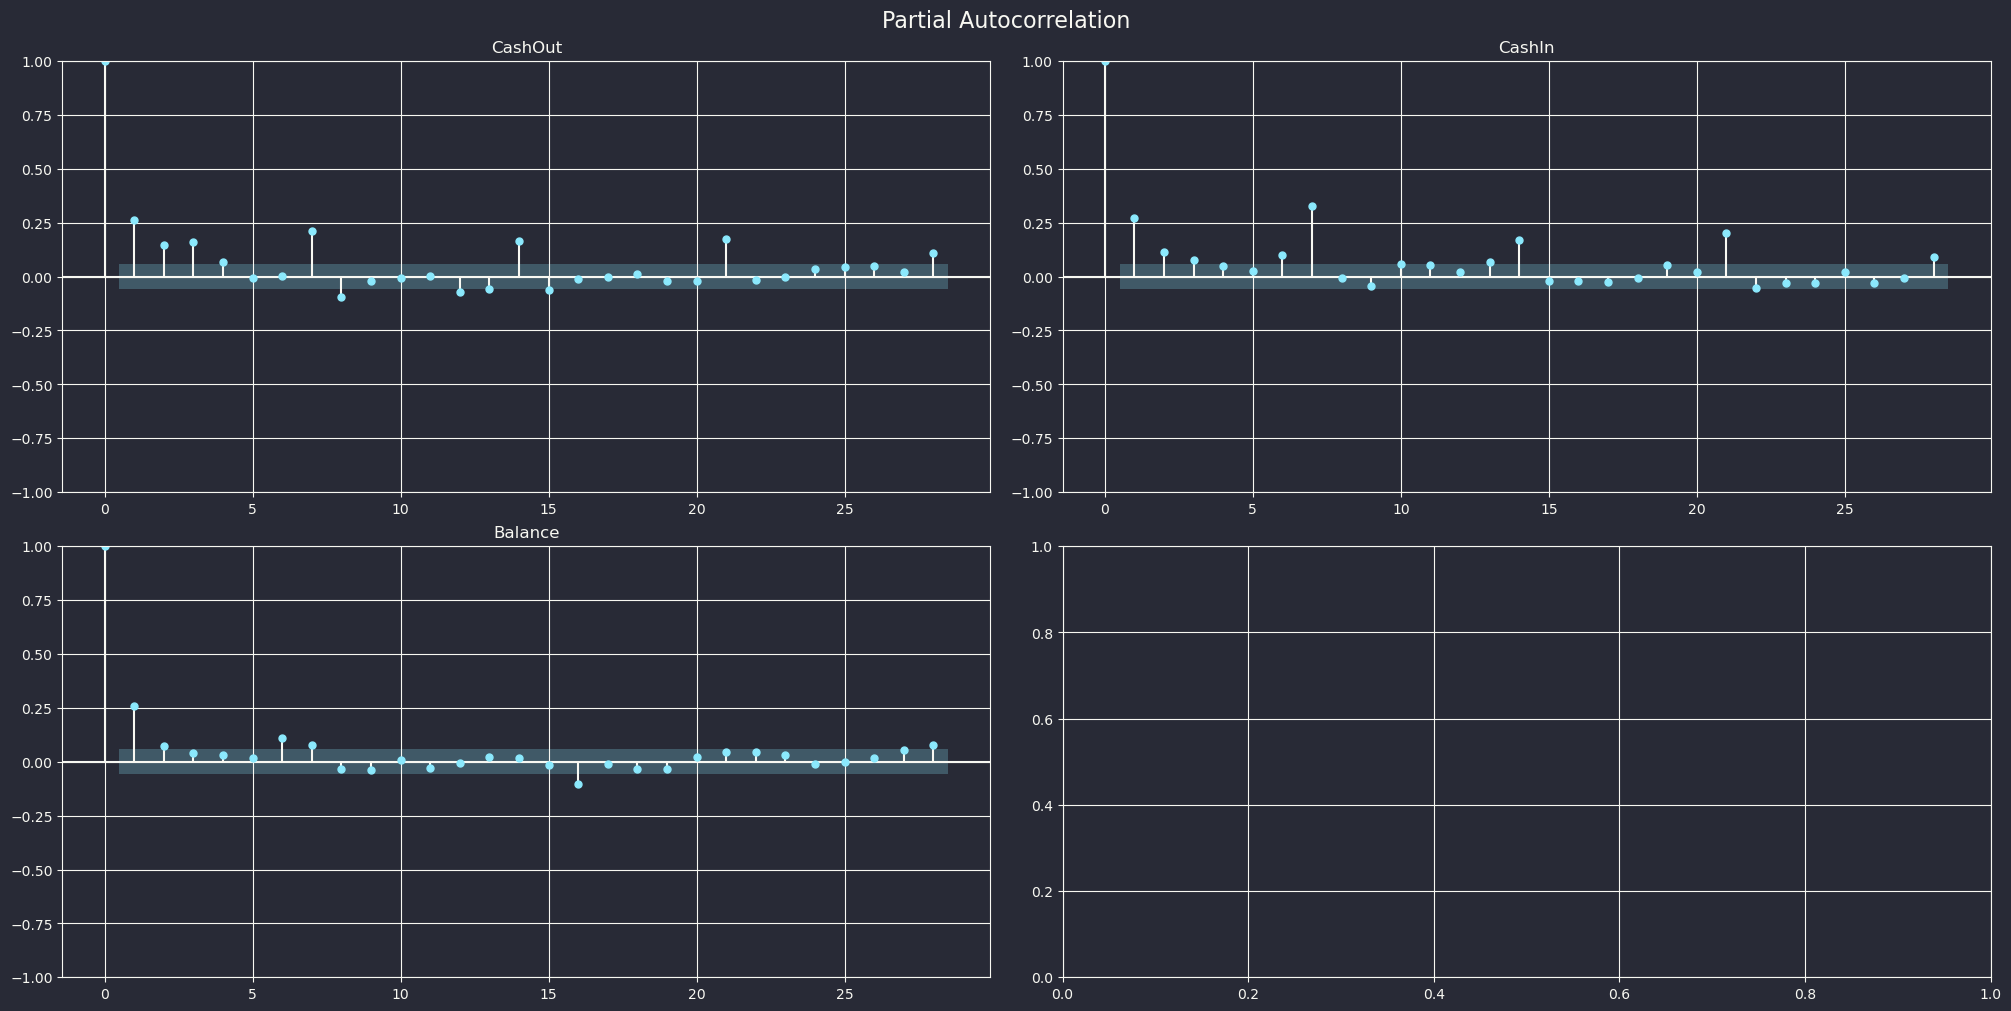

In [104]:
sample_pacf_plot(ts=ts_v1, lags=28)

> Очень явно проследываются две зависимости:
> 1. Вчерашний день – в какой-то степени можно считать отражением различных внешних факторов – текущие события, настроения общества и т.д. Они скорее всего будут иметь эффект на протежении нескольких дней, а не только одного.
> 2. Недельная периодичность – причины могут быть разные (выдача зарплат, выходные, распорядок дня). Довольго очевидно, особо добавить тут нечего.

> Таким образом в качестве лагов будем использовать `1, 7, 14, 21 и 28`

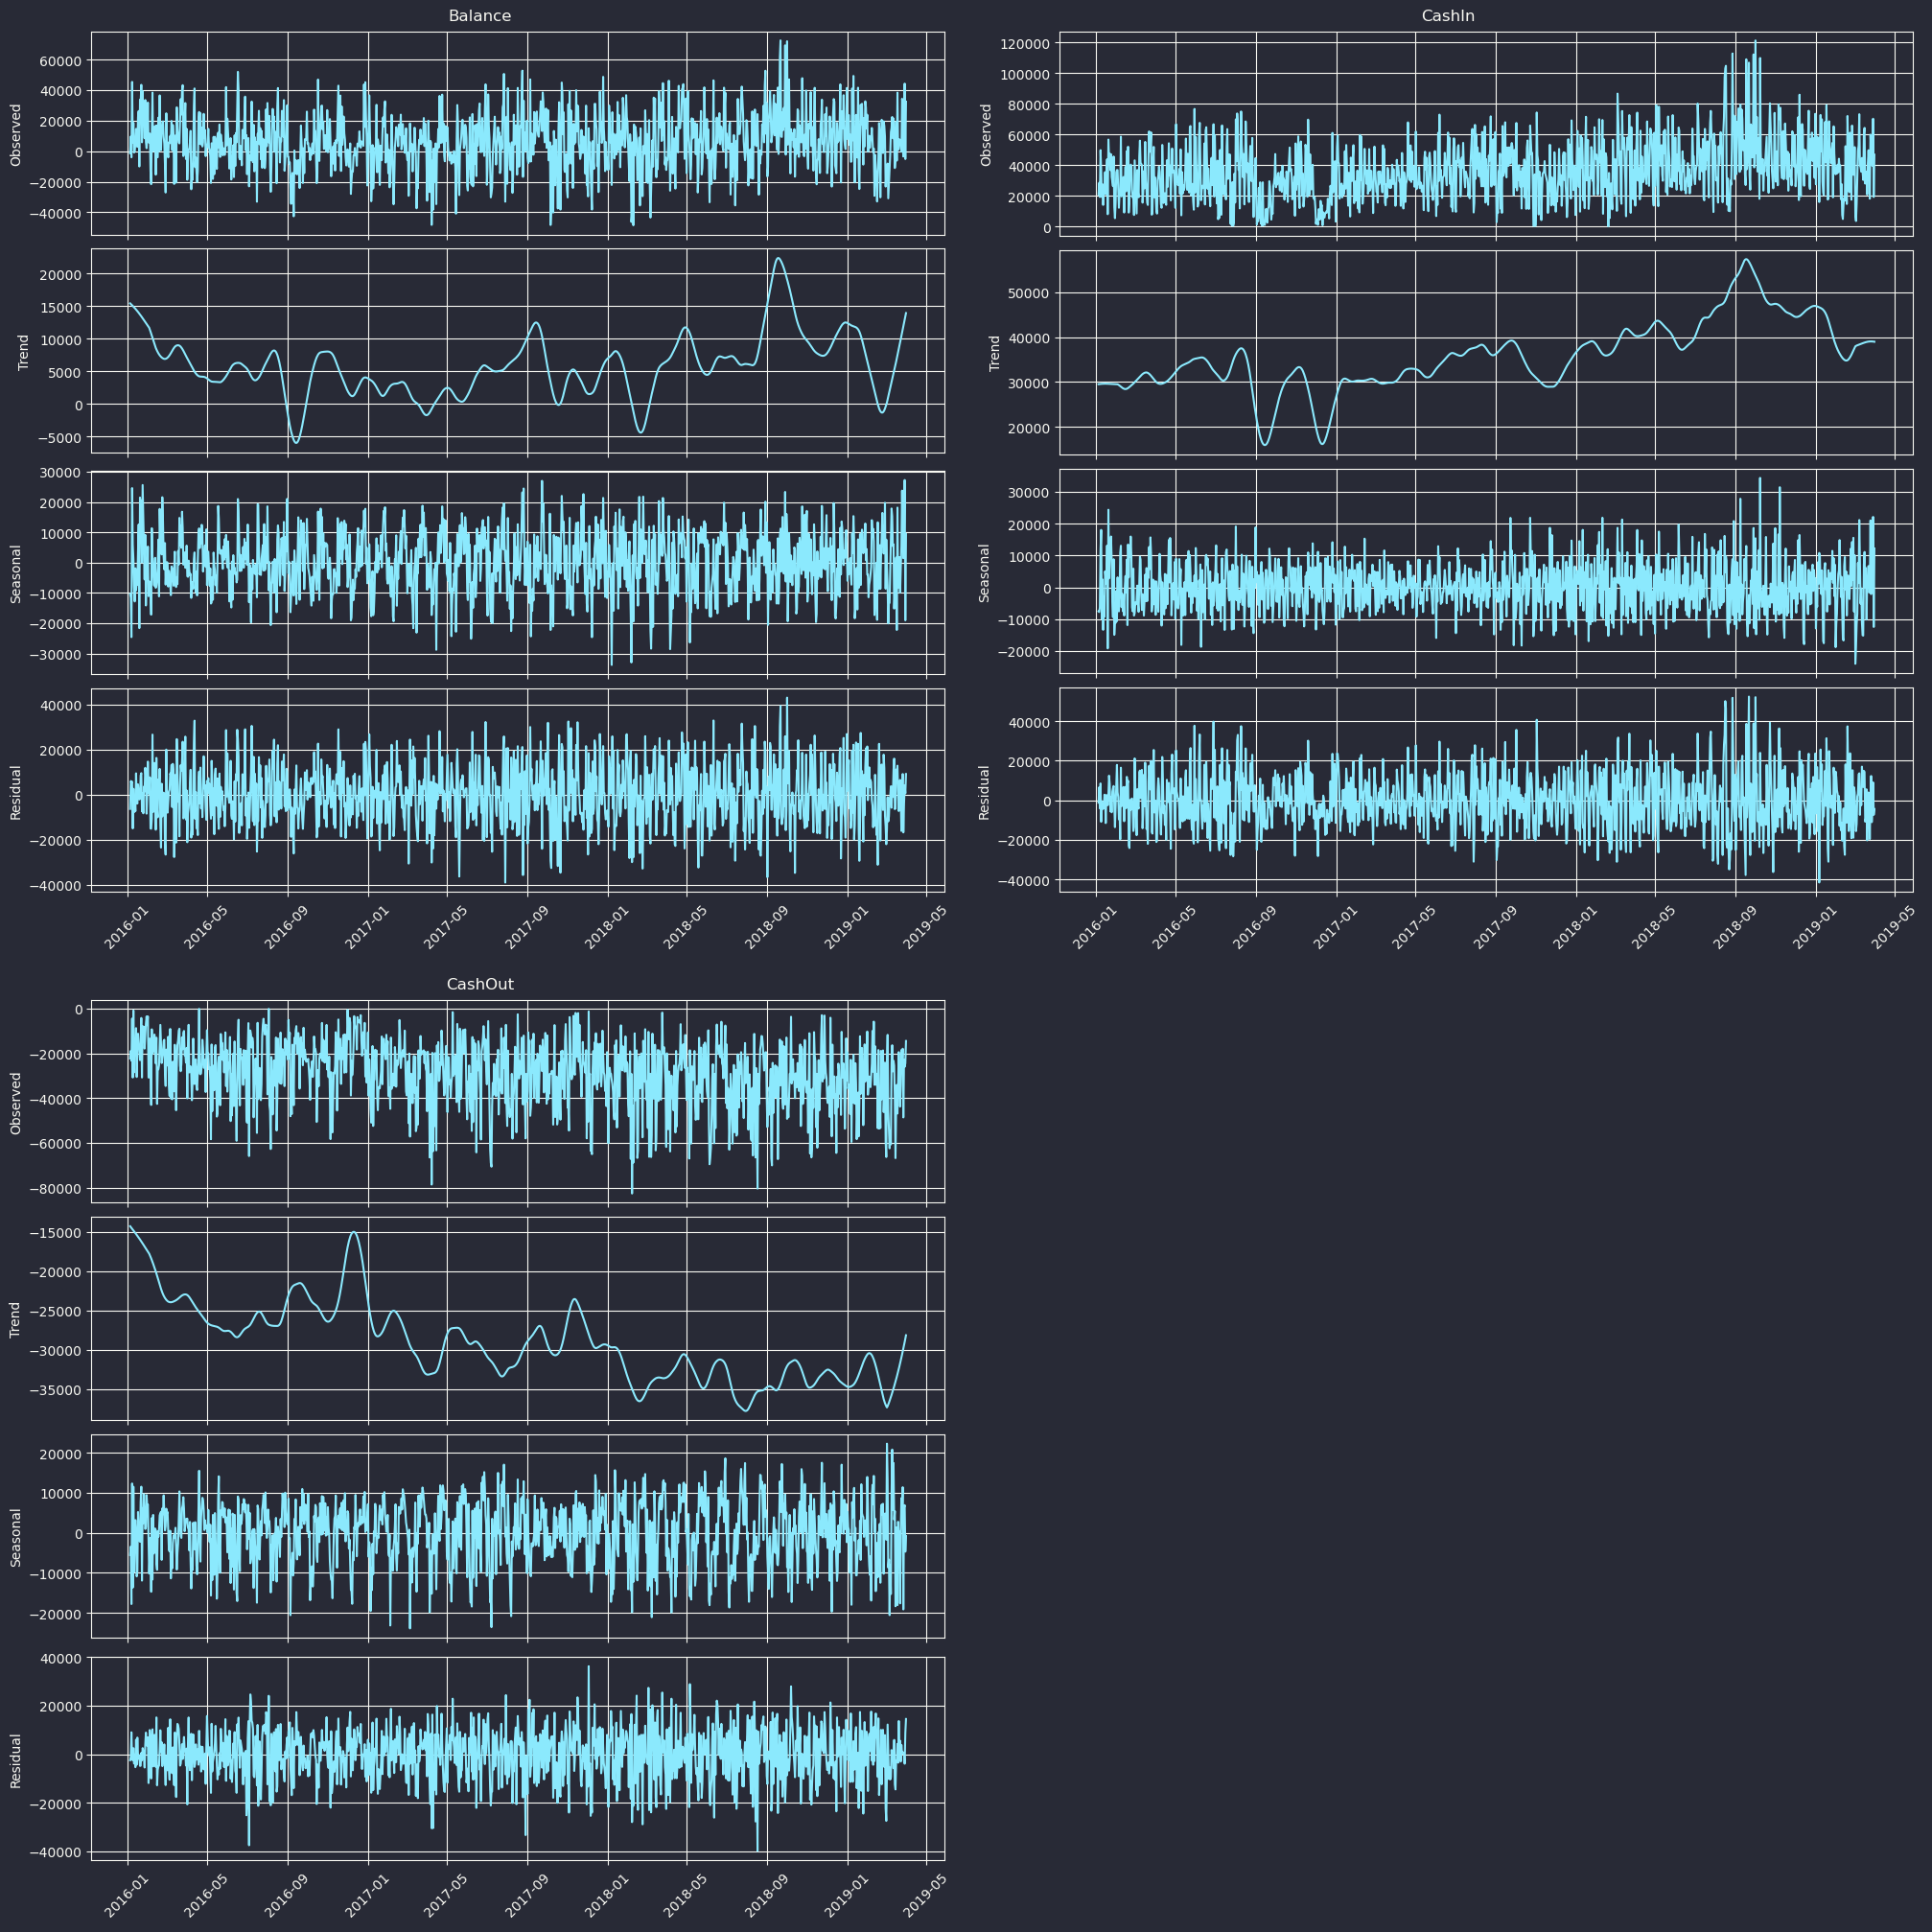

In [105]:
stl_plot(ts=ts_v1, period=30)

> При периодичности в 30 дней получаем относительно гладкий тренд и маленький residual

In [106]:
from etna.transforms import DateFlagsTransform, HolidayTransform, MeanTransform

transforms = [
    MeanTransform(in_column="target", window=7, out_column="mean_7"),
    MeanTransform(in_column="target", window=30, out_column="mean_30"),
    LagTransform(in_column="target", lags=[1, 2, 3, 7, 14, 21, 28], out_column="lag"),
    STLTransform(in_column="target", period=30),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        month_number_in_year=True,
        year_number=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    HolidayTransform(iso_code="TUR", out_column="holiday"),
    LagTransform(in_column="holiday", lags=[1, 2, 3], out_column="holiday_lag"),
    SegmentEncoderTransform(),
]

> 1. Средние по неделе и месяцу в качестве внешнего контекста, То же самое, как и со вчерашним днем.
> 2. Лаги – обсуждалось выше
> 3. STL – тренд, сезонность и тд
> 4. Даты – вполне очевидно, что такие списания и пополнения могут быть привязаны к опредленным дням недели и месяца – пополонения при получении зарплаты в начале месяца, отдых на выходных и тд.
> 5. Праздники и лаг праздников – в их районе можно ожидать увеличение снятий и пополнений, когда люди отдыхают или покупают/получают подарки
> 6. Разные ряды ведут себя по разному, так что закодируем их как категории

In [107]:
pipeline = Pipeline(
    transforms=transforms, model=CatBoostMultiSegmentModel(), horizon=HORIZON
)

metrics_df, _, _ = pipeline.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.9s finished


,segment,MAE,SMAPE
0,Balance,22522.099785,119.057497
1,CashIn,40923.646131,65.540729
2,CashOut,13576.318724,44.417880


In [108]:
pipeline = Pipeline(
    transforms=transforms, model=CatBoostPerSegmentModel(), horizon=HORIZON
)

metrics_df, _, _ = pipeline.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished


,segment,MAE,SMAPE
0,Balance,19009.138724,121.473718
1,CashIn,24128.073204,46.425649
2,CashOut,13073.112882,40.389311


In [109]:
pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=[SegmentEncoderTransform()],
    horizon=HORIZON,
)

metrics_df, _, _ = pipeline.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.5s finished


,segment,MAE,SMAPE
0,Balance,12725.505185,119.809994
1,CashIn,12326.754657,29.861961
2,CashOut,11414.749606,34.526320


> ### Примечание
> AutoARIMA по какой-бы то ни было причине очень не дружит с лагами и лучше всего работает если оставить только сегментной преобразование. Возможно это связано с тем, что многие из этих преобразований она проводит сама и добавленные нами признаки ее сбивают.

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [110]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [111]:
pipeline = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON, step=1
)
metrics_df, _, _ = pipeline.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.0s finished


,segment,MAE,SMAPE
0,Balance,18279.515399,130.576923
1,CashIn,21951.577947,55.261041
2,CashOut,17382.579110,48.104414


In [112]:
pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(), transforms=[], horizon=HORIZON, step=1
)
metrics_df, _, _ = pipeline.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


,segment,MAE,SMAPE
0,Balance,12488.361012,122.908222
1,CashIn,9978.587194,24.520645
2,CashOut,11484.654925,34.773760


In [113]:
horizons = [1, 3, 5]
models = [AutoARIMAModel()] * 3

ensemble = DirectEnsemble(
    assemble_pipelines(models=models, transforms=[SegmentEncoderTransform()], horizons=horizons)
)

metrics_df, _, _ = ensemble.backtest(ts=ts_v1, metrics=METRICS, aggregate_metrics=True)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend wit

,segment,MAE,SMAPE
0,Balance,12725.505185,119.809994
1,CashIn,12326.754657,29.861961
2,CashOut,11414.749606,34.526320


 > Авторегрессия дала более худшие результаты для котят (CatBoost), но хорошо помогла Ариме. Ансамбль из 3 Арим пока что дает наилучшие результаты – даже лучше Профета

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [114]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [115]:
transforms = [
    MeanTransform(in_column="target", window=7, out_column="mean_7"),
    MeanTransform(in_column="target", window=30, out_column="mean_30"),
    LagTransform(in_column="target", lags=[1, 2, 3, 7, 14, 21, 28], out_column="lag"),
    # STLTransform(in_column="target", period=30),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        month_number_in_year=True,
        year_number=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    HolidayTransform(iso_code="TUR", out_column="holiday"),
    LagTransform(in_column="holiday", lags=[1, 2, 3], out_column="holiday_lag"),
    SegmentEncoderTransform(),
]

In [119]:
catper_pipeline = Pipeline(
    model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON
)

catmulti_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON
)

arima_pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(), transforms=[], horizon=HORIZON
)

prophet_pipeline = AutoRegressivePipeline(
    model=ProphetModel(), transforms=transforms, horizon=HORIZON
)

In [120]:
voting_ensemble = VotingEnsemble(
    pipelines=[catper_pipeline, catmulti_pipeline, arima_pipeline, prophet_pipeline],
    weights=[1, 1, 5, 5],
)

> Попробуем побить наш рекорд, создав ансамбль из всех моделей, включая сам Prophet. Из предыдущих опытом известно, что Котята работают лучше на обычных пайплайнах, а Арима на авторегрессии. Для Профета тоже попробуем применить авторегрессию. Также уберем из пайплайна STL – эмпирическим путем выяснилось, что без декомпозиции результаты по какой-то причине лучше. Как моделям с наилучшими метриками дадим Ариме и Профету большие веса.

In [121]:
metrics_df, forecast_df, _ = voting_ensemble.backtest(
    ts=ts_v1, metrics=METRICS, aggregate_metrics=True, n_jobs=4
)
metrics_df

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/etna/models/sarimax.py:62: FutureWarning: warn is deprecated (and never implemented) and will be removed in a future version.
  freq = pd.infer_freq(df["timestamp"], warn=False)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done

,segment,MAE,SMAPE
0,Balance,13639.566558,121.705686
1,CashIn,11772.289363,28.226667
2,CashOut,11115.729403,33.476041


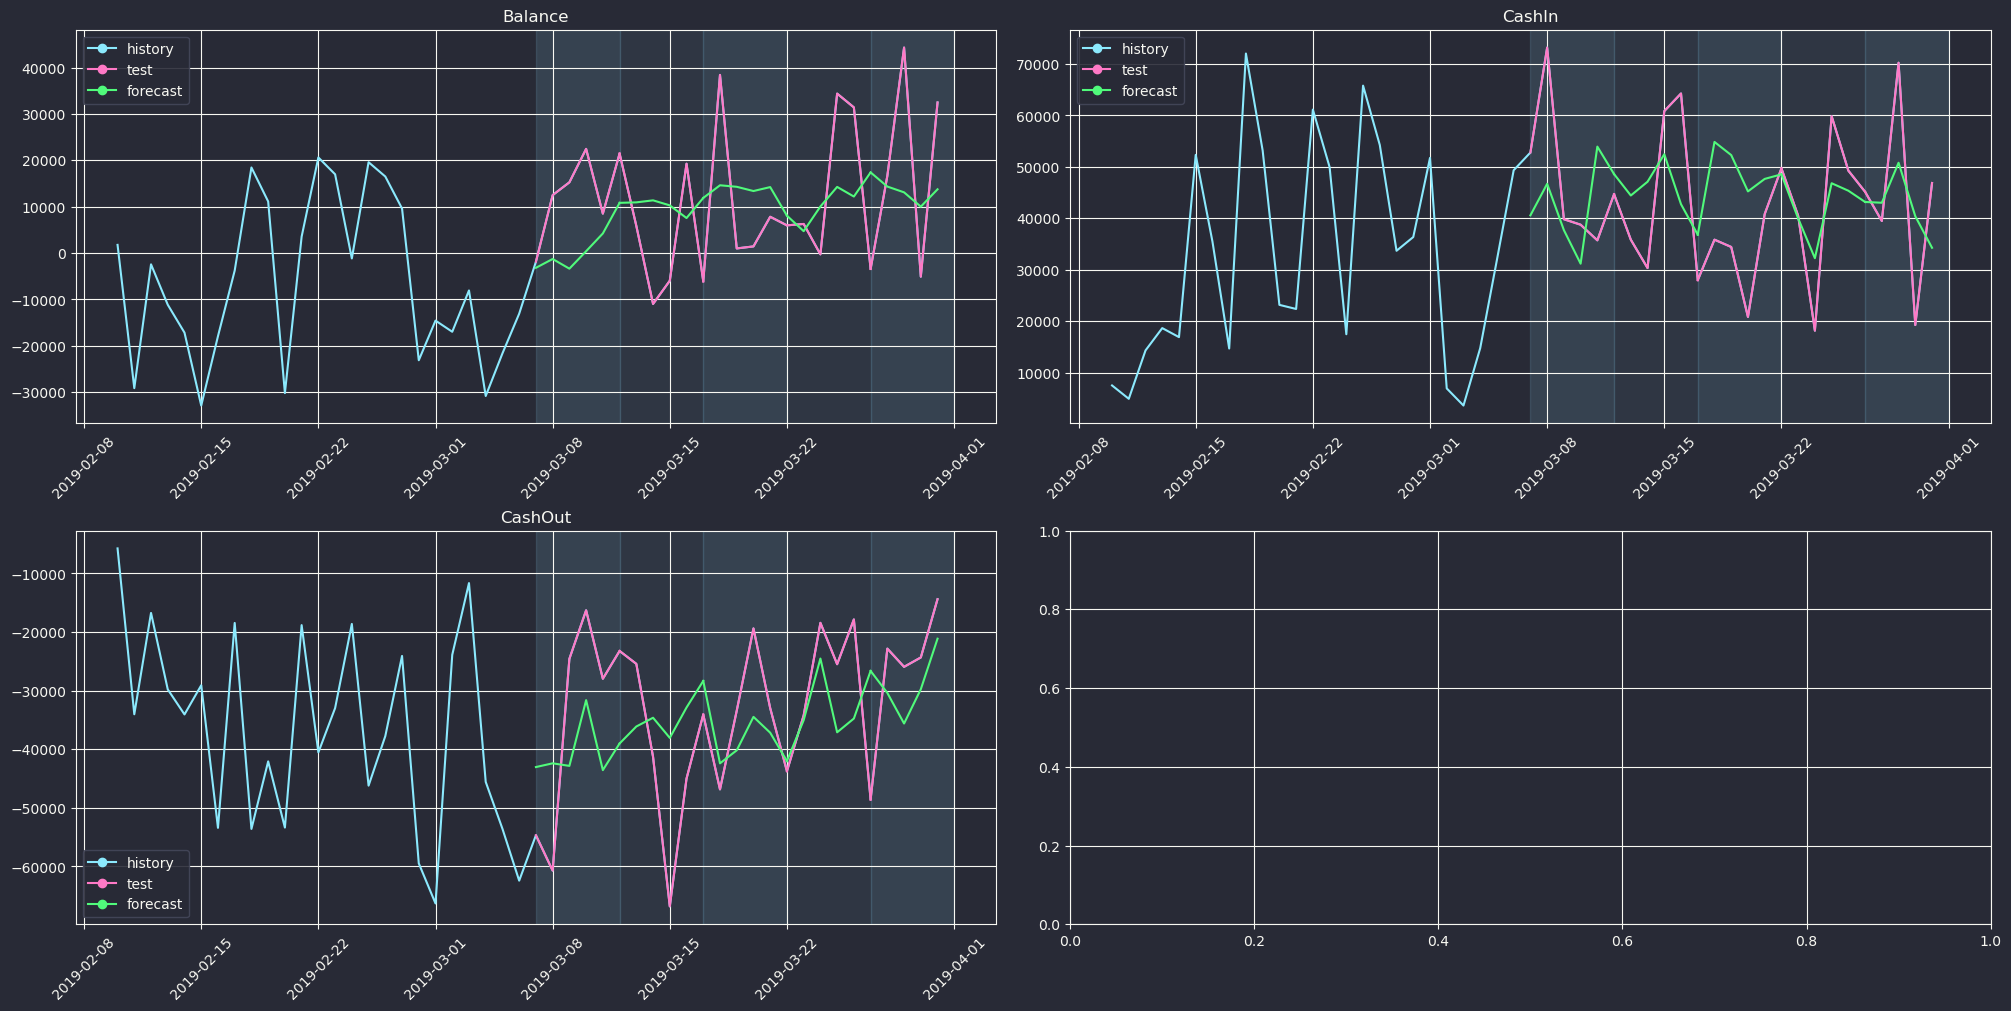

In [122]:
plot_backtest(forecast_df=forecast_df, ts=ts_v1, history_len=HISTORY)

> Ура – прирост хоть и небольшой, но все же лучше чем у ансамбля из 3 Арим и у Профета. Предсказания баланса не особо корректны, но в снятиях и пополнениях некоторые паттерны все же просматриваются. Во всех случаях усредненные предсказания так или иначе совпадают с тестовыми данными.

> Теперь попробуем то же самое, но уже со `StackingEnsemble`. Использовть добавленные нами фичи мы уже, к сожалению, не можем, так как Арима будет возвращать их как NaN.

In [123]:
stacking_ensemble = StackingEnsemble(
    pipelines=[catper_pipeline, catmulti_pipeline, arima_pipeline, prophet_pipeline],
    features_to_use=None,
)

In [124]:
metrics_df, forecast_df, _ = stacking_ensemble.backtest(
    ts=ts_v1, metrics=METRICS, aggregate_metrics=True, n_jobs=4
)
metrics_df

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/etna/datasets/tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 conc

,segment,MAE,SMAPE
0,Balance,15523.676751,135.614528
1,CashIn,12447.043773,31.731081
2,CashOut,11132.847066,33.585917


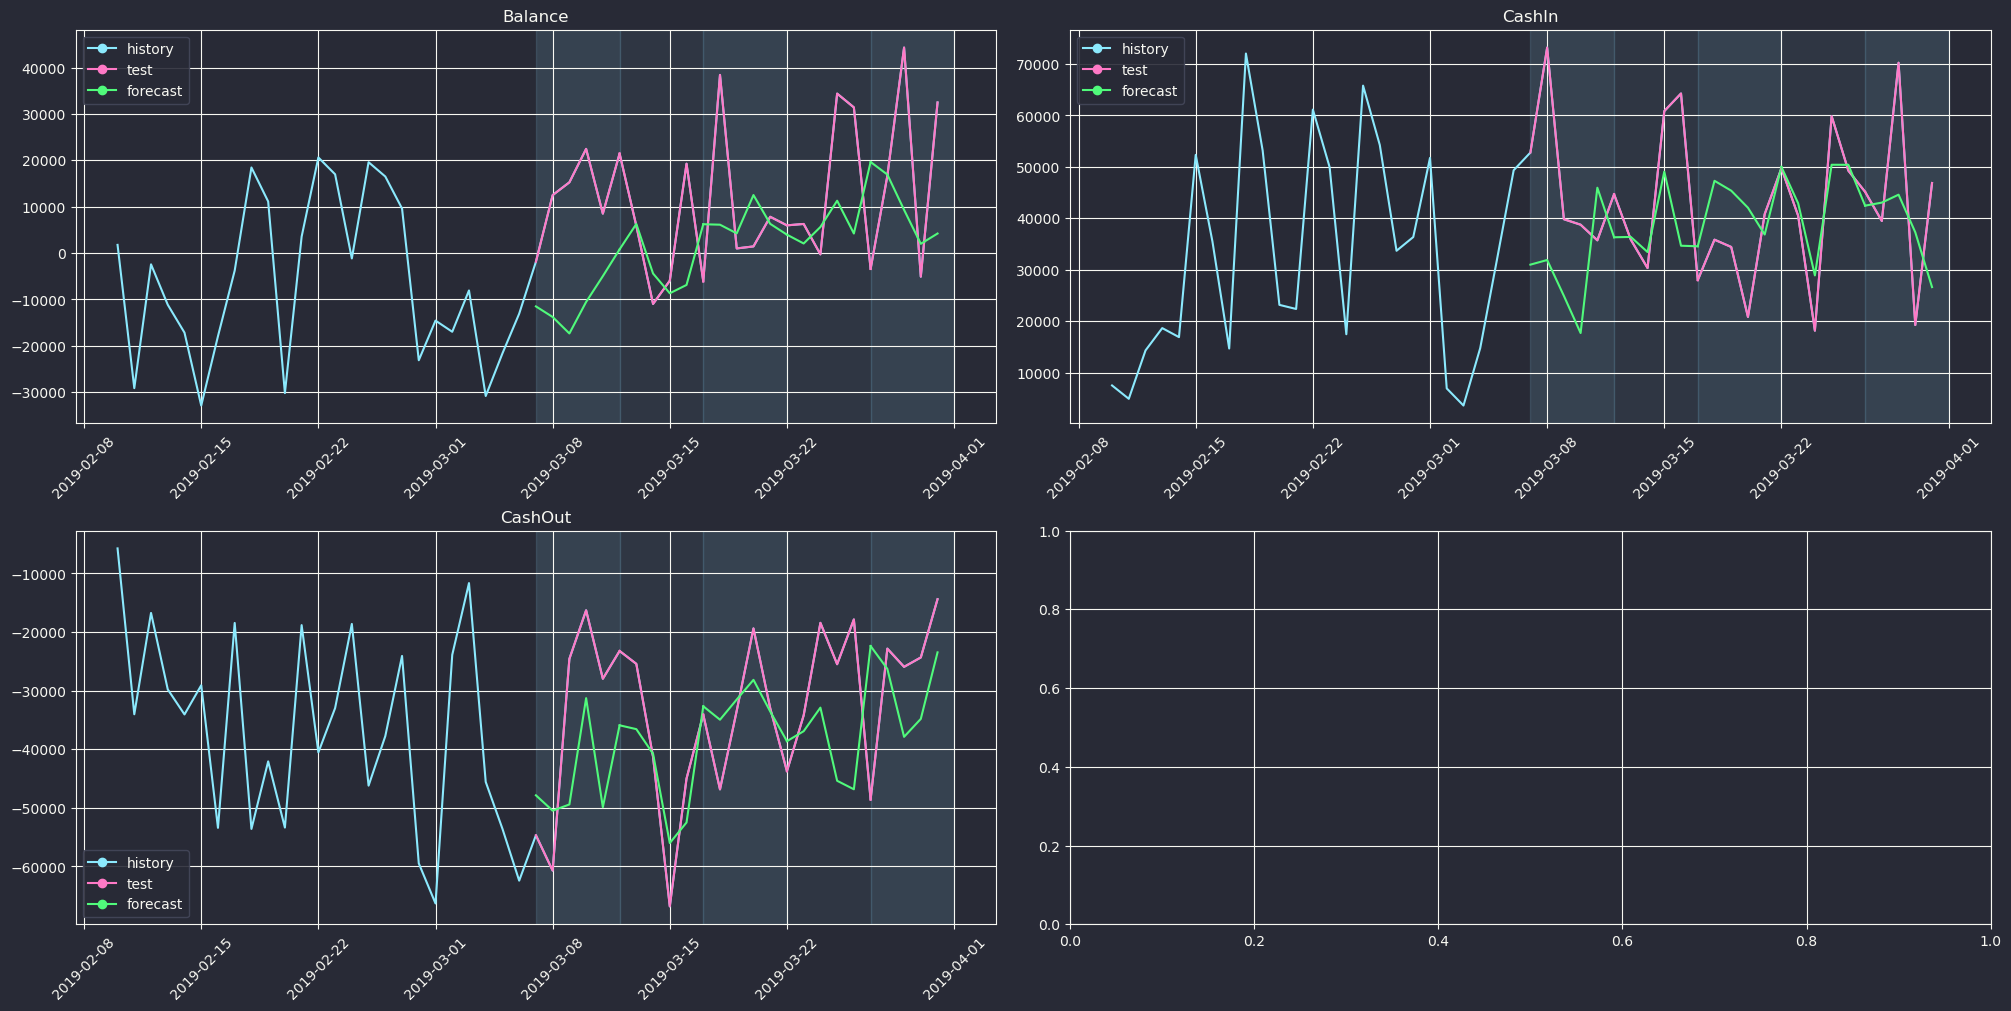

In [125]:
plot_backtest(forecast_df=forecast_df, ts=ts_v1, history_len=HISTORY)

> Результаты хоть и хороши, но далеки даже от обычных моделей Котят. Видимо модель, обучающаяся поверх, недостаточно хороша и/или ей не хватает добавленных нами параметров. Таким образом пока что наилучшей комбинацей остается `VotingEnsemble` с Аримой и Профетом

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#